# Introduction

Single particle tracking (SPT) analysis involves many steps. This notebook assumes that the tracking has already been performed on a set of images with *TrackMate*. We start from a set of CSV files that contain at least X and Y positions and a trajectory label. The idea will be to turn these trajectories into mean square displacement curves (MSDs) and extract all of the features of interest which will be stored in list that can be turned into a DataFrame. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from DF_functions import mean_msd,covariance_msd,theoretical_mean_msd,theoretical_covariance,Michalet
from functions import data_pool,NormMSDSlopeError,NormMSDInterceptError,NormMSDSlopeError_exp,NormMSDInterceptError_exp,fix_heatmap
from sklearn.linear_model import LinearRegression

%matplotlib inline
%reload_ext autoreload

# Experimental condition
dt = 0.05

# Initial filtering
minframe=12
maxframe=500
rsquared_threshold=0.9

# Process raw data

The raw data is a list of CSV files. The `data_pool` function processes these CSVs and returns a list of observations that can readily be turned into a `DataFrame`. 

    DATA = data_pool(list of CSV files,
    time step for the experiment dt,
    minimum number of frames for the trajectories,
    maximum number of frames for the trajectories,
    minimum value for the quality of the MSD fit R**2,
    fit_option = number of points for the fit of the MSD,
    images = set of images in order to compute the cell's mean intensity)


In [3]:
files1 = ["Data/SM1/sm1_ld400.csv","Data/SM2/sm2_ld400.csv","Data/SM3/sm3_ld400.csv","Data/SM4/sm4_ld400.csv","Data/SM5/sm5_ld400.csv","Data/SM6/sm6_ld400.csv","Data/SM7/sm7_ld400.csv","Data/SM8/sm8_ld400.csv","Data/SM9/sm9_ld400.csv","Data/SM10/sm10_ld400.csv"]
images1 = ["Data/SM1/sm1_stack.tif","Data/SM2/sm2_stack.tif","Data/SM3/sm3_stack.tif","Data/SM4/sm4_stack.tif","Data/SM5/sm5_stack.tif","Data/SM6/sm6_stack.tif","Data/SM7/sm7_stack.tif","Data/SM8/sm8_stack.tif","Data/SM9/sm9_stack.tif","Data/SM10/sm10_stack.tif"]

files2 = ["Data/SM1_WNT/sm1_wnt_ld400.csv","Data/SM2_WNT/sm2_wnt_ld400.csv","Data/SM3_WNT/sm3_wnt_ld400.csv","Data/SM4_WNT/sm4_wnt_ld400.csv","Data/SM5_WNT/sm5_wnt_ld400.csv","Data/SM6_WNT/sm6_wnt_ld400.csv","Data/SM7_WNT/sm7_wnt_ld400.csv","Data/SM8_WNT/sm8_wnt_ld400.csv","Data/SM10_WNT/sm10_wnt_ld400.csv"]
images2 = ["Data/SM1_WNT/sm1_wnt_stack.tif","Data/SM2_WNT/sm2_wnt_stack.tif","Data/SM3_WNT/sm3_wnt_stack.tif","Data/SM4_WNT/sm4_wnt_stack.tif","Data/SM5_WNT/sm5_wnt_stack.tif","Data/SM6_WNT/sm6_wnt_stack.tif","Data/SM7_WNT/sm7_wnt_stack.tif","Data/SM8_WNT/sm8_wnt_stack.tif","Data/SM10_WNT/sm10_wnt_stack.tif"]

DATA1 = data_pool(files1,dt,minframe,maxframe,rsquared_threshold,images=images1,fit_option=3)
DATA2 = data_pool(files2,dt,minframe,maxframe,rsquared_threshold,images=images2,fit_option=3)

/home/remy13127/Documents/Internship/functions.py:732: RuntimeWarning: divide by zero encountered in double_scalars
  rsquare = 1 - result.residual.var() / np.var(rhon[n0:nbrpts])


# Prepare DataFrames

The DATA-list contains either 9 or 10 features (if a set of images was provided). It is a list of $N_T$ observations and each observation is a set of 9-10 features. 

$$
\begin{pmatrix}
[ \alpha_1 & D_1 & c_1 & N_1 & \text{ID}_1 & X_1 & Y_1 & \text{MSD}_1 & \text{FILE}_1 & I_1 ]\\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
[\alpha_{N_T} & D_{N_T} & c_{N_T} & N_{N_T} & \text{ID}_{N_T} & X_{N_T} & Y_{N_T} & \text{MSD}_{N_T} & \text{FILE}_{N_T} & I_{N_T}] \\
\end{pmatrix}
$$

Such an object can be readily turned into a dataframe with `pandas`. 

In [14]:
df1 = pd.DataFrame(DATA1,columns=['alpha', 'D', 'c','N','ID','x','y','MSD','Filename','I'])
df2 = pd.DataFrame(DATA2,columns=['alpha', 'D', 'c','N','ID','x','y','MSD','Filename','I'])
#Apply transformation to a column
df1['D'] = df1['D'].map(lambda x: np.log10(x))
df2['D'] = df2['D'].map(lambda x: np.log10(x))

df1.sample(10).head()

,alpha,D,c,N,ID,x,y,MSD,Filename,I
508,0.934033,-0.844279,0.212725,23,8511,"[34.246, 34.291, 34.172, 34.159, 33.918, 33.89...","[14.693, 14.517000000000001, 14.48299999999999...","[0.03612440909090912, 0.064877142857143, 0.098...",Data/SM3/sm3_ld400.csv,656
383,1.281912,-0.284800,0.562704,12,4349,"[39.321, 39.39, 39.495, 39.222, 39.047, 39.129...","[1.455, 1.621, 1.67, 1.9240000000000002, 2.070...","[0.046610727272727234, 0.10625270000000009, 0....",Data/SM3/sm3_ld400.csv,636
1398,0.806178,-1.001549,0.211301,26,4223,"[19.541, 19.702, 19.539, 19.723, 19.653, 19.53...","[64.268, 64.21300000000001, 64.10300000000001,...","[0.03941264000000007, 0.05639504166666674, 0.0...",Data/SM10/sm10_ld400.csv,684
228,1.220648,-0.395972,0.424804,18,617,"[21.392, 21.105, 20.901, 20.555999999999997, 2...","[22.52, 22.743000000000002, 22.935, 23.076, 23...","[0.04061835294117625, 0.09772137499999986, 0.1...",Data/SM3/sm3_ld400.csv,640
53,0.168431,-1.899047,0.227508,12,2858,"[27.395, 27.372, 27.269000000000002, 27.27, 27...","[0.14400000000000002, 0.295, 0.27, 0.293, 0.32...","[0.03029990909090897, 0.034655100000000265, 0....",Data/SM1/sm1_ld400.csv,623


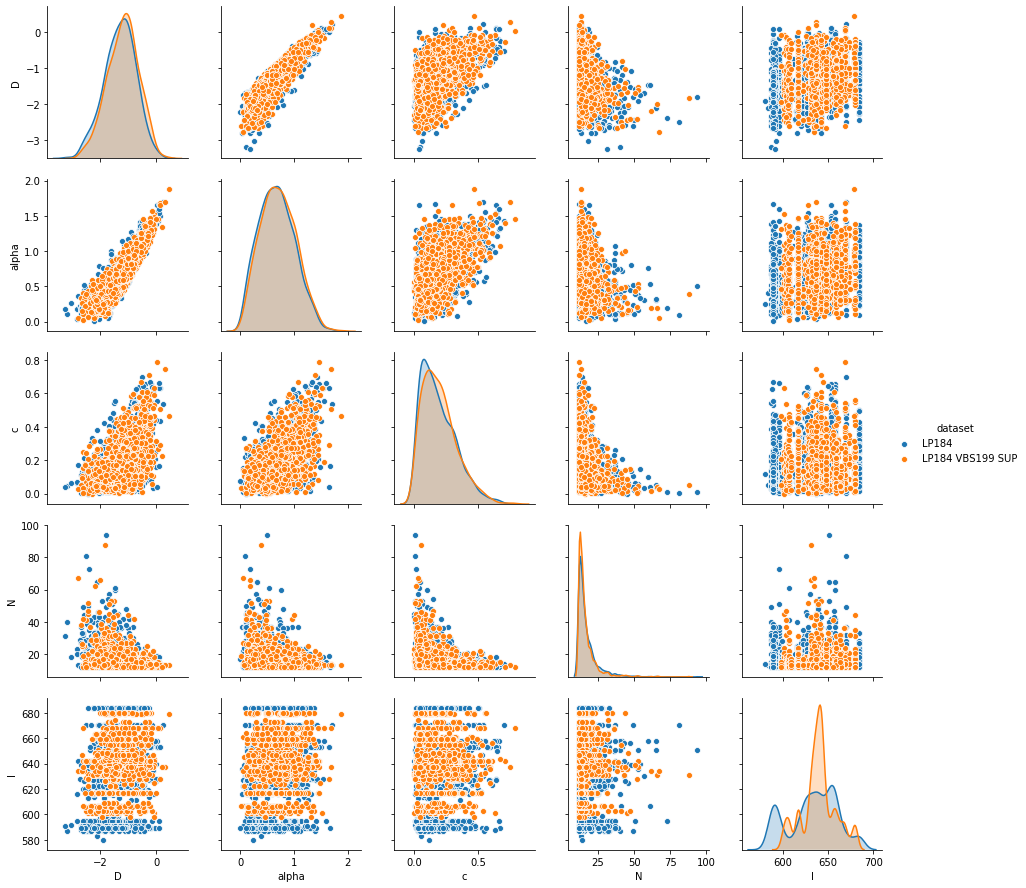

In [13]:
# Concatenate all data
concatenated = pd.concat([df1.assign(dataset='LP184'), df2.assign(dataset='LP184 VBS199 SUP')])
sns.pairplot(concatenated[['D','alpha','c','N','I','dataset']],hue='dataset')
plt.show()

#sns.pairplot(df1[['D','alpha','c','I','N']])
#sns.pairplot(df2[['D','alpha','c','I','N']])

# Free diffusion analysis on a subset of the data

We can try to isolate the most freely diffusing population from the data and estimate the diffusion coefficient using the known properties of Brownian systems. Michalet developed a full theoretical framework for Brownian trajectories. The characteristics of our supposedly Brownian data will be compared to Michalet's theoretical expressions with the `Michalet` function. 

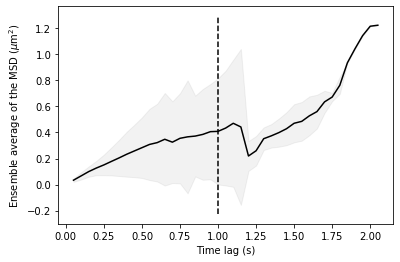

Initial run to determine the best theoretical values for D and sigma.
It is estimated that the lowest error will be for a number of fitting points P =  4  for which the relative error sigma/b =  0.9788374370098701
D =  0.1566
It is estimated that the lowest error will be when the number of fitting points P =  4  for which the relative error sigmaa/a =  0.014379132903149655
sigma =  0.0276
Second run with accurate values for D and sigma.
D =  0.1566
sigma =  0.0276
Done.


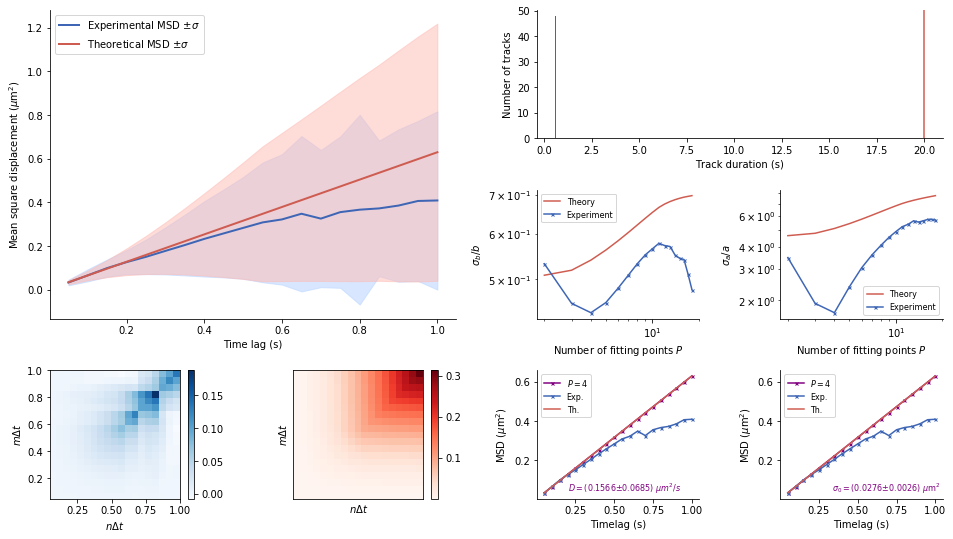

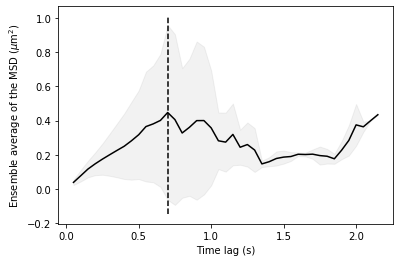

Initial run to determine the best theoretical values for D and sigma.
It is estimated that the lowest error will be for a number of fitting points P =  4  for which the relative error sigma/b =  1.1993954029128322
D =  0.1825
It is estimated that the lowest error will be when the number of fitting points P =  4  for which the relative error sigmaa/a =  0.016348203659247135
sigma =  0.0314
Second run with accurate values for D and sigma.
D =  0.1825
sigma =  0.0314
Done.


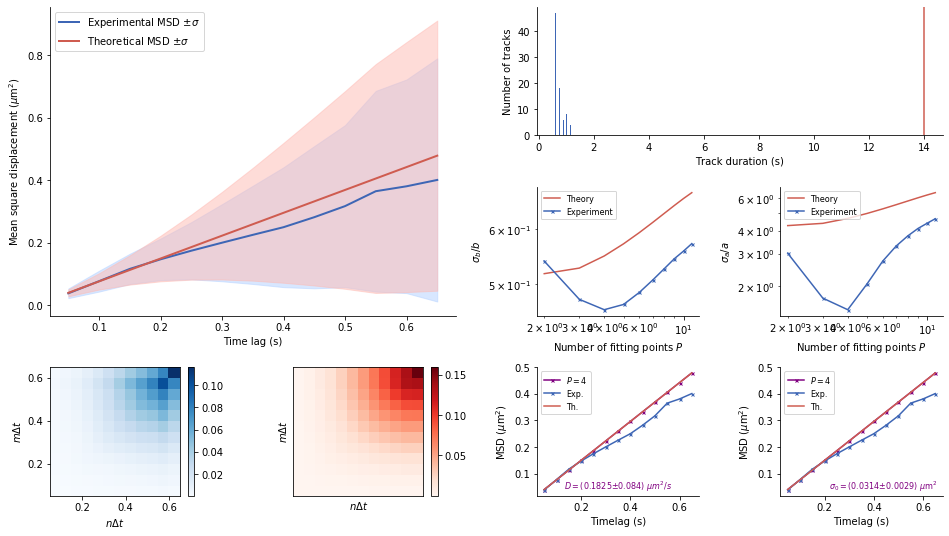

In [21]:
#Filter on alpha
dfilt1 = df1[(df1['alpha']<1.1) & (df1['alpha']>0.9)]
dfilt2 = df2[(df2['alpha']<1.1) & (df2['alpha']>0.9)]

#Select the Dataset and extract MSDs
MSDSeries1 = dfilt1['MSD'].values
cutoff1 = 1
Michalet(MSDSeries,dt=dt,cutoff=cutoff1)
#mmsd,mvar,timelag = mean_msd(MSDSeries,cutoff=cutoff,show_cutoff=True)

MSDSeries2 = dfilt2['MSD'].values
cutoff2 = 0.7
Michalet(MSDSeries2,dt=dt,cutoff=cutoff2)